# Предсказание кумулятивного значения угла

## Импорт библиотек

In [ ]:
!pip install tensorly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 4.7 MB/s 
     |████████████████████████████████| 154 kB 52.1 MB/s 


In [ ]:
import PIL
from PIL import Image, ImageSequence
import imageio
import glob
import cv2

import numpy as np
import pandas as pd
import scipy.stats as sps
from numpy.linalg import norm

import tensorly as tl
import torch as t
import hopls

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

from sklearn.metrics import \
    mean_absolute_percentage_error as mape, \
    mean_squared_error as mse, \
    mean_absolute_error as mae, \
    r2_score as r2
from tqdm import tqdm

In [ ]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 42

## Чтение данных, создание траекторных матриц

In [ ]:
cap = cv2.VideoCapture('start_video_6min.avi')
video = []
last_frame = None
MARKER_THRESHOLD = 192

while cap.isOpened():
    # Capture frame-by-frame
    # frame.shape = (H, W. C)
    ret, frame = cap.read()

    if ret:
        last_frame = frame
        bool_frame = frame.mean(axis=-1) >= MARKER_THRESHOLD
        video.append(bool_frame)
    else:
        break

video = np.array(video, dtype=bool)    
cap.release()
cv2.destroyAllWindows()

In [ ]:
target_df = pd.read_csv(
    'start_target_cum.csv'
)
angles = target_df.iloc[:, 1:].values.reshape(-1, 2, 1)

In [ ]:
FREQ_REDUCTION_COEF = 3
MAX_TS_LEN = 1500
TEST_SIZE = 300
test_video = video[::FREQ_REDUCTION_COEF][MAX_TS_LEN:MAX_TS_LEN+TEST_SIZE]
video = video[::FREQ_REDUCTION_COEF][:MAX_TS_LEN]
test_angles = angles[::FREQ_REDUCTION_COEF][MAX_TS_LEN:MAX_TS_LEN+TEST_SIZE]
angles = angles[::FREQ_REDUCTION_COEF][:MAX_TS_LEN]

In [ ]:
TRAJ_SIZE = 3
traj_video = tl.tensor(
    [video[i:i+TRAJ_SIZE] for i in range(len(video)-TRAJ_SIZE+1)],
)
traj_angles = tl.tensor(
    [angles[i:i+TRAJ_SIZE] for i in range(len(angles)-TRAJ_SIZE+1)],
)
traj_test_video = tl.tensor(
    [test_video[i:i+TRAJ_SIZE] for i in range(len(test_video)-TRAJ_SIZE+1)],
)
traj_test_angles = tl.tensor(
    [test_angles[i:i+TRAJ_SIZE] for i in range(len(test_angles)-TRAJ_SIZE+1)],
)
del video

/usr/local/lib/python3.8/dist-packages/tensorly/backend/pytorch_backend.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(data, dtype=dtype, device=device,


## Применение HOSVD

In [ ]:
# Trains near 15 minutes
KERNEL_SIZE = 48
Ln = [TRAJ_SIZE, KERNEL_SIZE, KERNEL_SIZE]
Km = [TRAJ_SIZE, 2, 1]
epsilon = 1e-3
R = 30

model = hopls.HOPLS(R, Ln, Km, epsilon=epsilon)
model.fit(traj_video, traj_angles)
prediction, _, prediction_scores = model.predict(traj_video, traj_angles)

/usr/local/lib/python3.8/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


## Зависимость качества предсказания от кол-ва скрытых компонент

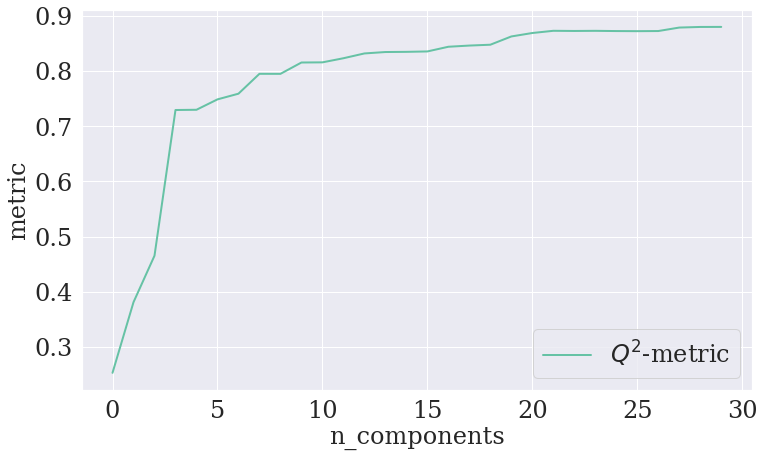

In [ ]:
scores = list(map(lambda x: x.item(), prediction_scores))
plt.plot(scores, label='$Q^2$-metric')
plt.xlabel('n_components')
plt.ylabel('metric')

plt.legend()
plt.savefig('metric-vs-components.png')
plt.show()

## Обработка предсканий, сравнение с истинной целевой переменной

In [ ]:
def transform_traj_elem(traj_elem: np.ndarray) -> np.ndarray:
    assert traj_elem.ndim >= 3, 'Too low dimensions'
    ts, traj_dim = traj_elem.shape[:2]
    result = np.zeros((traj_dim+ts-1, traj_elem.shape[2]))

    traj_elem = traj_elem.squeeze()
    norm_coef = np.full(traj_dim+ts-1, traj_dim)

    for i in range(ts):
        if i < traj_dim:
            norm_coef[i] = i + 1
            norm_coef[-i-1] = i + 1
        
        result[i:i+traj_dim, :] += traj_elem[i]

    return result / norm_coef.reshape(-1, 1)


predicted_angles = transform_traj_elem(prediction.numpy())

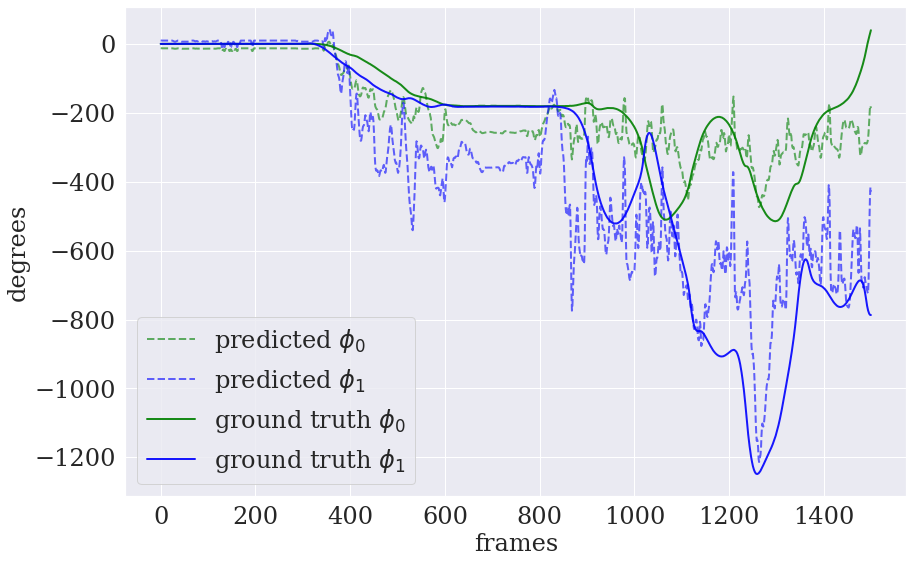

<Figure size 864x504 with 0 Axes>

In [ ]:
# Predictions for training time series
plt.figure(figsize=(14, 9))
plt.plot(predicted_angles[:, 0], '--', c='green', alpha=0.6, label=r'predicted $\phi_0$')
plt.plot(predicted_angles[:, 1], '--', c='blue', alpha=0.6, label=r'predicted $\phi_1$')
plt.plot(angles[:, 0], c='green', alpha=0.9, label=r'ground truth $\phi_0$')
plt.plot(angles[:, 1], c='blue', alpha=0.9, label=r'ground truth $\phi_1$')

plt.xlabel('frames')
plt.ylabel('degrees')
plt.legend()
plt.show()
plt.savefig('train_example.png')

**Значения метрик**

In [ ]:
print("MSE for phi_0 =", mse(angles[:, 0], predicted_angles[:, 0]))
print("MAE for phi_0 =", mae(angles[:, 0], predicted_angles[:, 0]))
print("R^2 for phi_0 =", r2(angles[:, 0], predicted_angles[:, 0]))

print("MSE for phi_1 =", mse(angles[:, 1], predicted_angles[:, 1]))
print("MAE for phi_1 =", mae(angles[:, 1], predicted_angles[:, 1]))
print("R^2 for phi_1 =", r2(angles[:, 1], predicted_angles[:, 1]))

MSE for phi_0 = 7541.819966955796
MAE for phi_0 = 63.92701135063991
R^2 for phi_0 = 0.6624092999668558
MSE for phi_1 = 27799.948430547047
MAE for phi_1 = 120.5553358198868
R^2 for phi_1 = 0.7776599416017695


## Получение предсказания на тестовой выборке

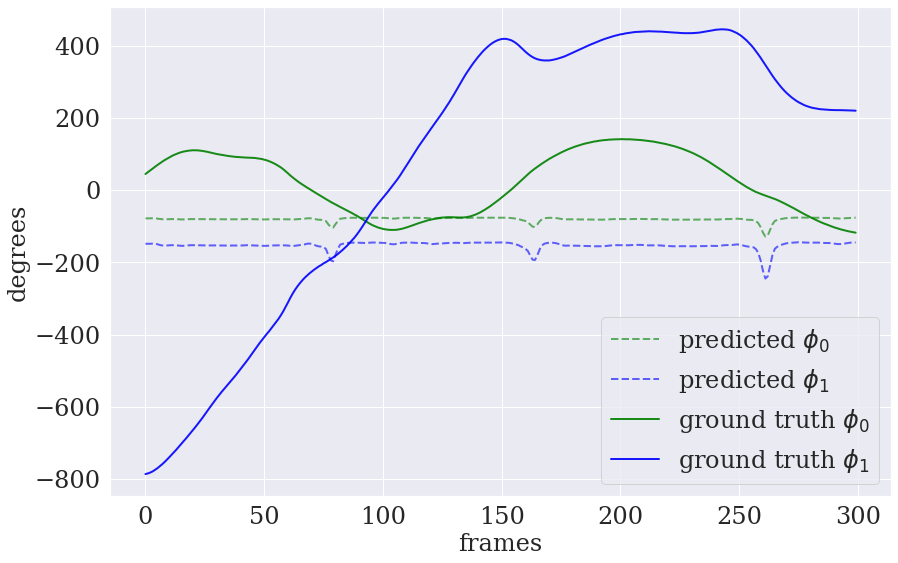

<Figure size 864x504 with 0 Axes>

In [ ]:
test_prediction, _, _ = hopls.predict(traj_test_video, traj_test_angles)
test_predicted_angles = transform_traj_elem(test_prediction.numpy())

plt.figure(figsize=(14, 9))
plt.plot(test_predicted_angles[:, 0], '--', c='green', alpha=0.6, label=r'predicted $\phi_0$')
plt.plot(test_predicted_angles[:, 1], '--', c='blue', alpha=0.6, label=r'predicted $\phi_1$')
plt.plot(test_angles[:, 0], c='green', alpha=0.9, label=r'ground truth $\phi_0$')
plt.plot(test_angles[:, 1], c='blue', alpha=0.9, label=r'ground truth $\phi_1$')

plt.xlabel('frames')
plt.ylabel('degrees')
plt.legend()
plt.show()
plt.savefig('test_example.png')

## Построение фазовых траекторий

**Для временного ряда углов**

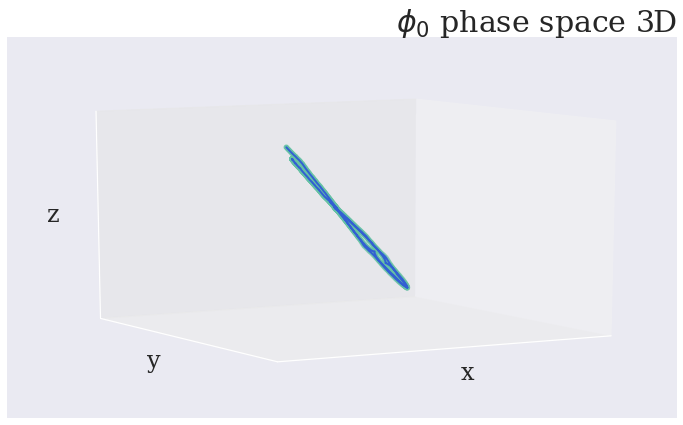

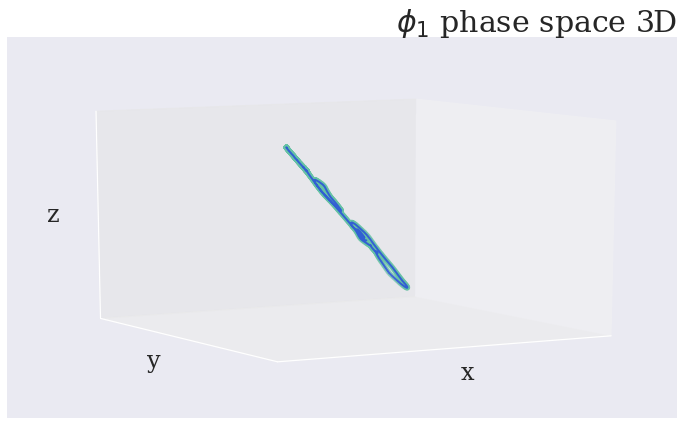

In [ ]:
# The function is taken from the notebook of Nikita Kornilov
# https://colab.research.google.com/drive/1nTKB3h5RPus7BXE9H-Qwa1an0Q6YUkH0?usp=share_link#scrollTo=XGznjPsrr0jE
def plot_phase_trajectory(points, use_lines = True, name = '', to_save = False):
    '''
    Plot phase space of series, phase trajectory of series.
    Parameters
    ----------
    points: numpy.ndarray of shape (K, 3 or 2)
        Points in phase space.
    name: str
        Name of plot.
    '''
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_title(name + ' phase space 3D', loc ='right')
    
    xs = points[:,0]
    ys = points[:,1]
    zs = points[:,2]
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    if use_lines:
        ax.plot(xs, ys, zs, c='b', alpha=0.5)
    ax.scatter(xs, ys, zs)
    ax.view_init(elev=10., azim=60)

    # Remove ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.zaxis.set_ticks([])

    if to_save:
        fig.savefig(name + '_phase_space.png')


plot_phase_trajectory(traj_angles.numpy()[:, :, 0, 0], name=r'$\phi_0$', to_save=True)
plot_phase_trajectory(traj_angles.numpy()[:, :, 1, 0], name=r'$\phi_1$', to_save=True)

**Для временного ряда видео**

In [ ]:
from sklearn.manifold import TSNE


tsne = TSNE(3, random_state=SEED)
video_embedded = tsne.fit_transform(traj_video.numpy().reshape(traj_video.shape[0], -1))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


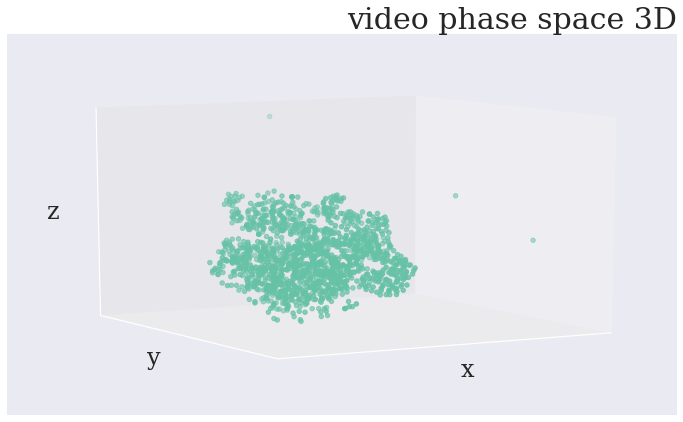

In [ ]:
plot_phase_trajectory(video_embedded, use_lines=False, name='video', to_save=True)

## Grid Search по числу компонент HOPLS (R) и размерности core tensor-а

In [ ]:
# Grid Search works 2.5 hours
kernel_sizes = (16, 32, 48)
Km = [TRAJ_SIZE, 2, 1]
epsilon = 1e-3
r_arr = (16, 32, 48)

metrics = {
    'phi_0': {
        'train': {
            'mse': [],
            'mae': [],
            'mape': [],
            'r2': []
        },
        'test': {
            'mse': [],
            'mae': [],
            'mape': [],
            'r2': []
        }
    },
    'phi_1': {
        'train': {
            'mse': [],
            'mae': [],
            'mape': [],
            'r2': []
        },
        'test': {
            'mse': [],
            'mae': [],
            'mape': [],
            'r2': []
        }
    }
}
q2_scores = []
predicted = []
test_predicted = []

for kernel_size in tqdm(kernel_sizes):
    for r in tqdm(r_arr):
        Ln = [TRAJ_SIZE, kernel_size, kernel_size]

        model = hopls.HOPLS(r, Ln, Km, epsilon=epsilon)
        model.fit(traj_video, traj_angles)
        prediction, _, prediction_scores = model.predict(traj_video, traj_angles)
        test_prediction, _, _ = model.predict(traj_test_video, traj_test_angles)

        scores = list(map(lambda x: x.item(), prediction_scores))
        predicted_angles = transform_traj_elem(prediction.numpy())
        test_predicted_angles = transform_traj_elem(test_prediction.numpy())

        del model, prediction, test_prediction

        q2_scores.append(scores)
        predicted.append(predicted_angles)
        test_predicted.append(test_predicted_angles)

        metrics['phi_0']['train']['mse'].append(mse(angles[:, 0], predicted_angles[:, 0]))
        metrics['phi_0']['train']['mae'].append(mae(angles[:, 0], predicted_angles[:, 0]))
        metrics['phi_0']['train']['mape'].append(mape(angles[:, 0], predicted_angles[:, 0]))
        metrics['phi_0']['train']['r2'].append(r2(angles[:, 0], predicted_angles[:, 0]))

        metrics['phi_0']['test']['mse'].append(mse(test_angles[:, 0], test_predicted_angles[:, 0]))
        metrics['phi_0']['test']['mae'].append(mae(test_angles[:, 0], test_predicted_angles[:, 0]))
        metrics['phi_0']['test']['mape'].append(mape(test_angles[:, 0], test_predicted_angles[:, 0]))
        metrics['phi_0']['test']['r2'].append(r2(test_angles[:, 0], test_predicted_angles[:, 0]))

        metrics['phi_1']['train']['mse'].append(mse(angles[:, 1], predicted_angles[:, 1]))
        metrics['phi_1']['train']['mae'].append(mae(angles[:, 1], predicted_angles[:, 1]))
        metrics['phi_1']['train']['mape'].append(mape(angles[:, 1], predicted_angles[:, 1]))
        metrics['phi_1']['train']['r2'].append(r2(angles[:, 1], predicted_angles[:, 1]))

        metrics['phi_1']['test']['mse'].append(mse(test_angles[:, 1], test_predicted_angles[:, 1]))
        metrics['phi_1']['test']['mae'].append(mae(test_angles[:, 1], test_predicted_angles[:, 1]))
        metrics['phi_1']['test']['mape'].append(mape(test_angles[:, 1], test_predicted_angles[:, 1]))
        metrics['phi_1']['test']['r2'].append(r2(test_angles[:, 1], test_predicted_angles[:, 1]))

 33%|███▎      | 1/3 [04:42<09:24, 282.39s/it]/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'

 67%|██████▋   | 2/3 [13:45<07:15, 435.48s/it]/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'

 33%|███▎      | 1/3 [06:46<13:33, 406.55s/it]/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In part

**Сохранение предсказаний**

In [ ]:
import json


with open('metrics.json', 'w') as fp:
    json.dump(metrics, fp)

np.save('predicted.npy', np.array(predicted))
np.save('test_predicted.npy', np.array(test_predicted))
np.save('q2_scores.npy', np.array(q2_scores))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


## Визуализация полученных результатов

**Визуализация метрики**

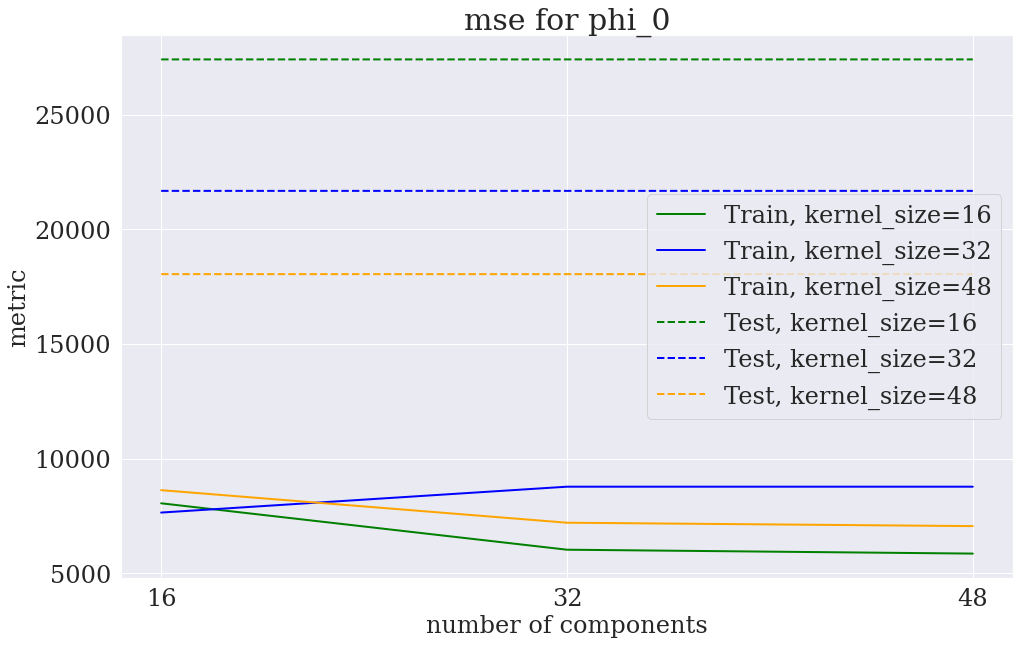

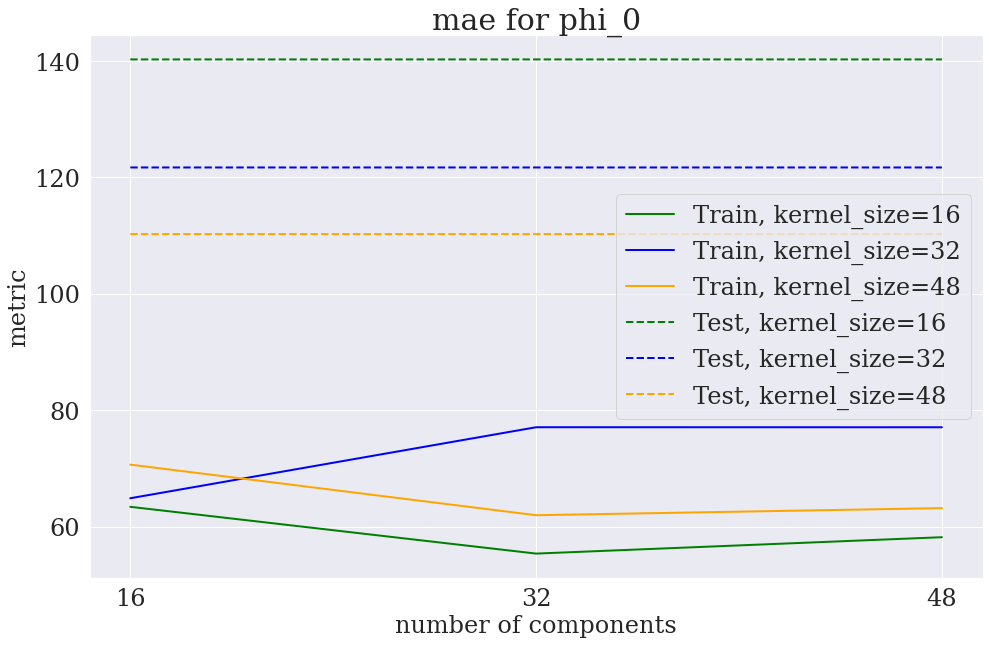

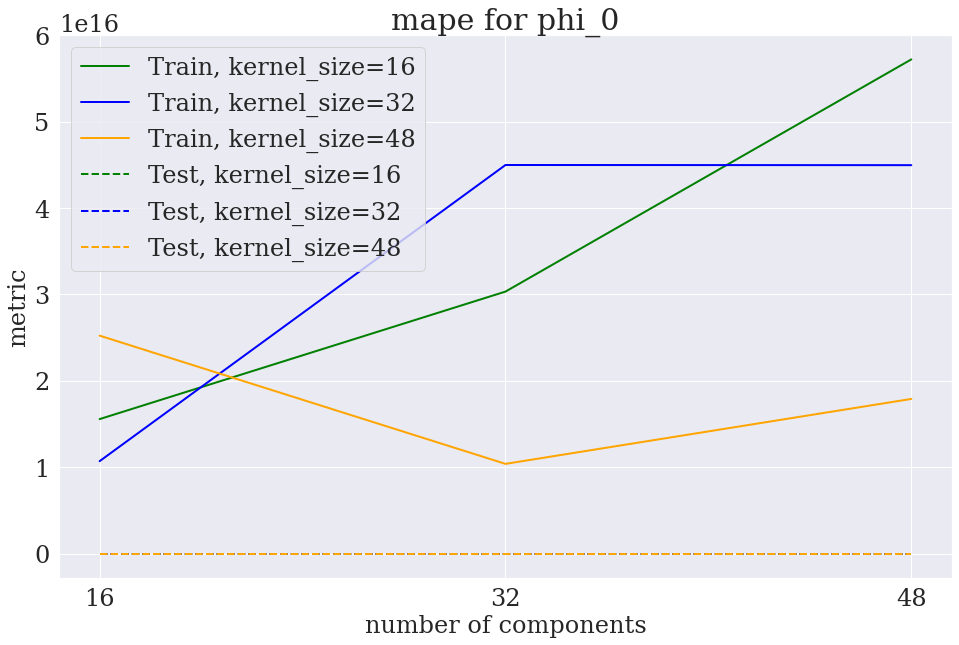

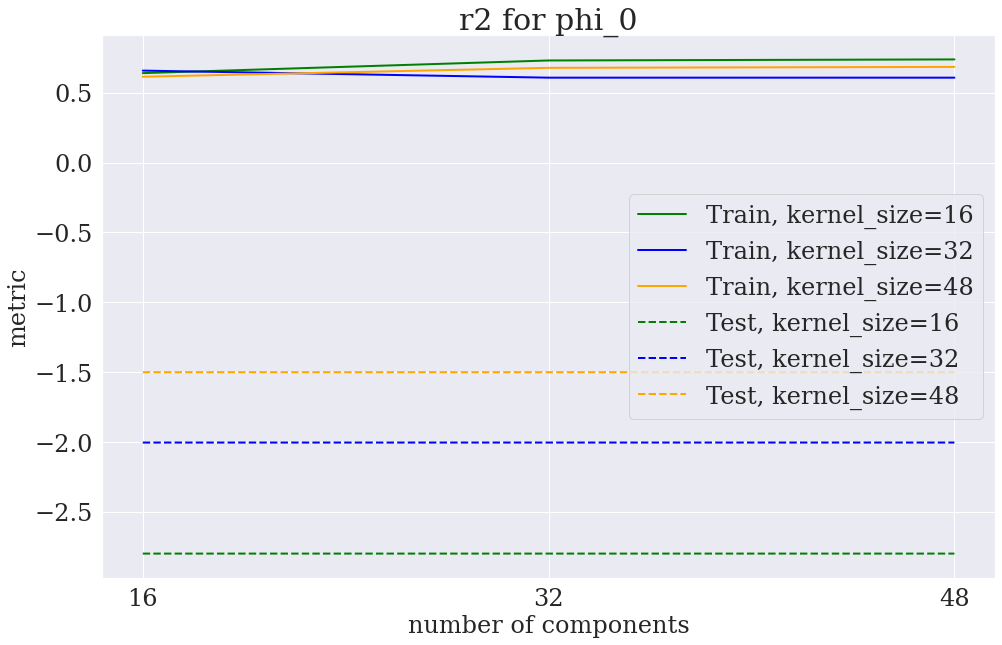

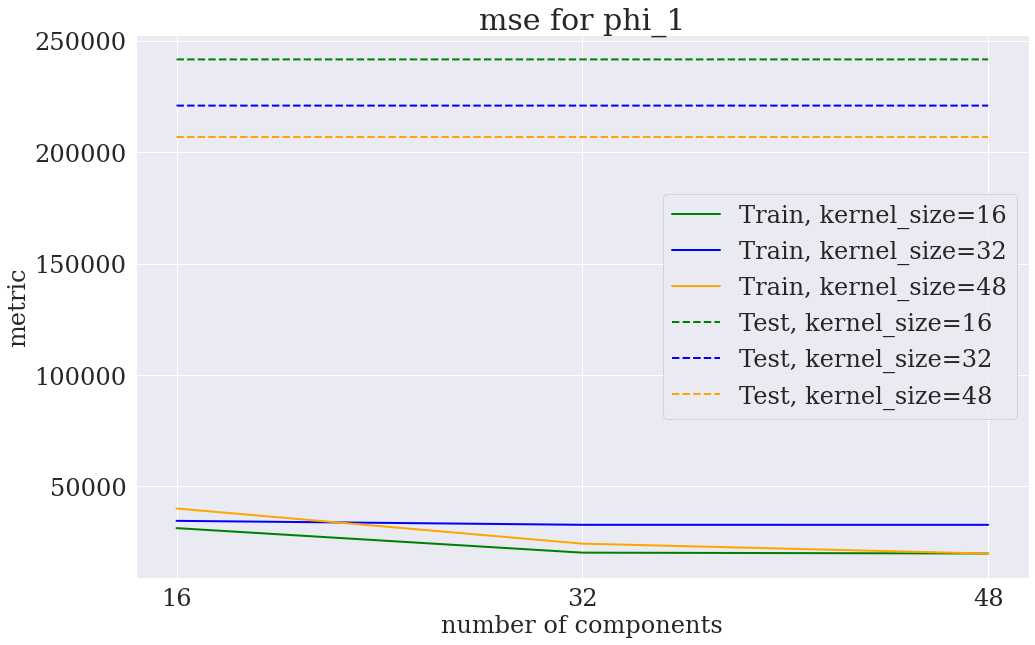

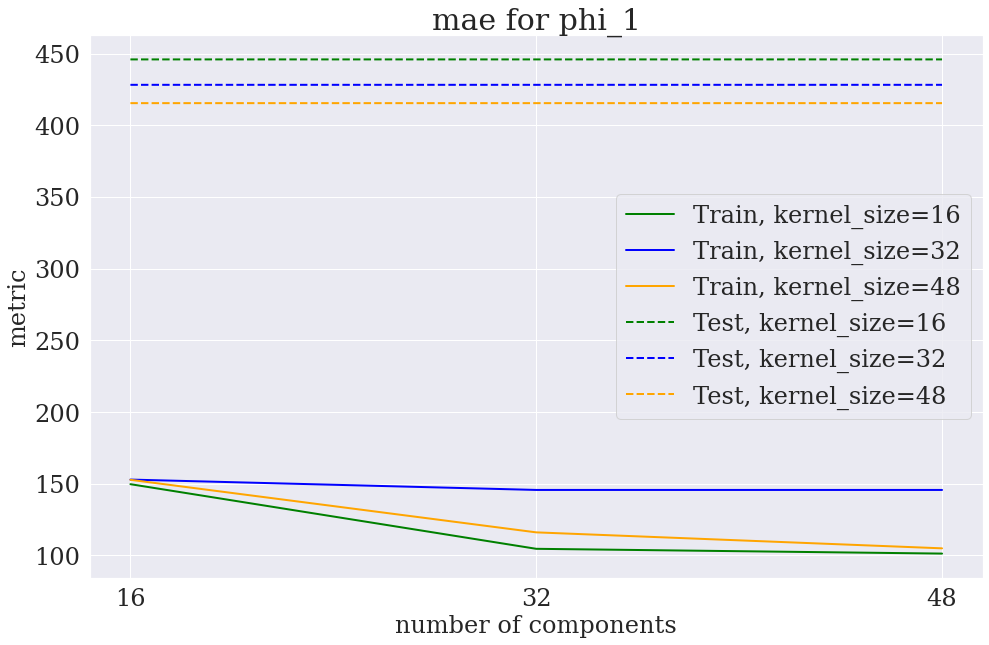

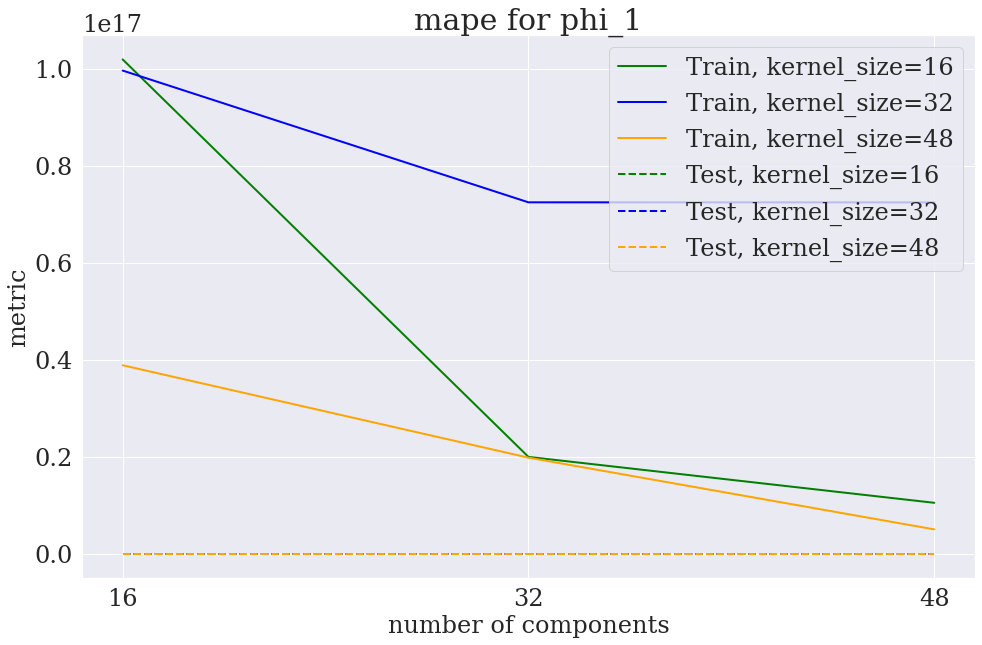

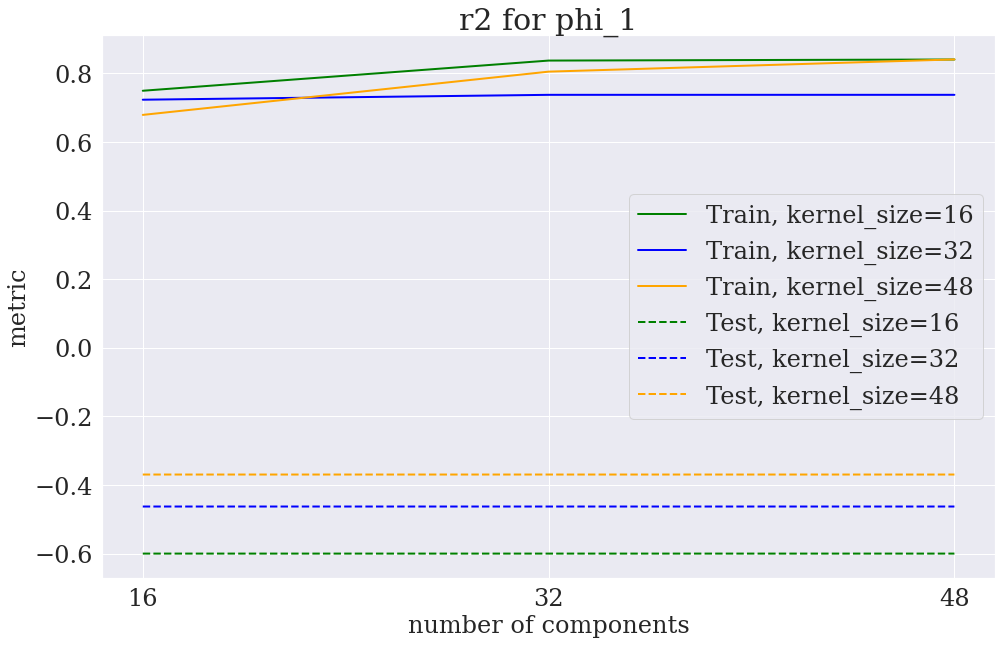

In [ ]:
for phi in ['phi_0', 'phi_1']:
    for metric in ['mse', 'mae', 'mape', 'r2']:
        plt.figure(figsize=(16, 10))
        plt.plot(
            metrics[phi]['train'][metric][:3],
            color='green',
            label=f'Train, kernel_size={kernel_sizes[0]}'
        )
        plt.plot(
            metrics[phi]['train'][metric][3:6],
            color='blue',
            label=f'Train, kernel_size={kernel_sizes[1]}'
        )
        plt.plot(
            metrics[phi]['train'][metric][6:],
            color='orange',
            label=f'Train, kernel_size={kernel_sizes[2]}'
        )

        plt.plot(
            metrics[phi]['test'][metric][:3],
            '--',
            color='green',
            label=f'Test, kernel_size={kernel_sizes[0]}'
        )
        plt.plot(
            metrics[phi]['test'][metric][3:6],
            '--',
            color='blue',
            label=f'Test, kernel_size={kernel_sizes[1]}'
        )
        plt.plot(
            metrics[phi]['test'][metric][6:],
            '--',
            color='orange',
            label=f'Test, kernel_size={kernel_sizes[2]}'
        )

        plt.xlabel('number of components')
        plt.xticks(ticks=range(len(r_arr)), labels=[str(r) for r in r_arr])
        plt.ylabel('metric')
        plt.title(f'{metric} for {phi}')
        plt.legend()
        plt.savefig(f'{metric}_for_{phi}.png')
        plt.show()

**Визуализация предсказаний на обучении**

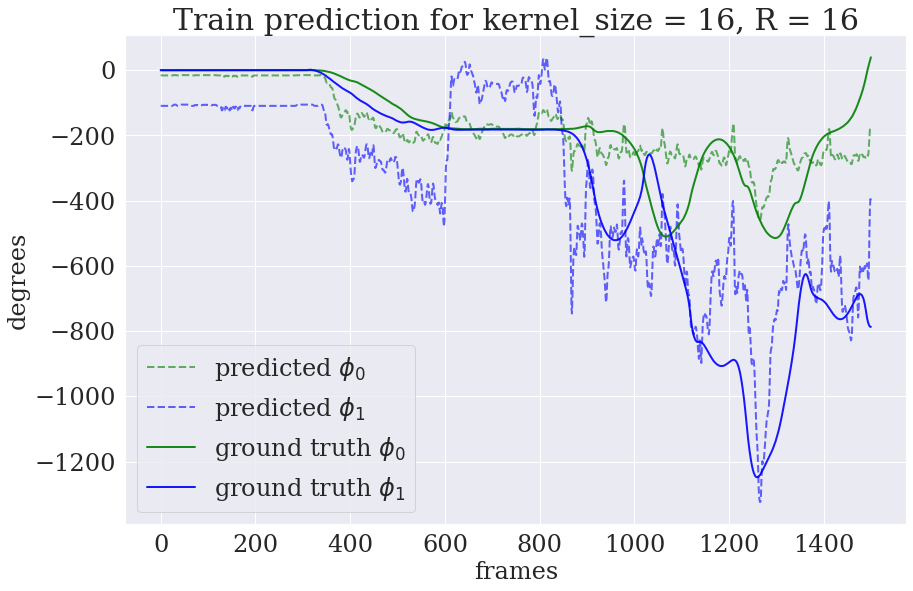

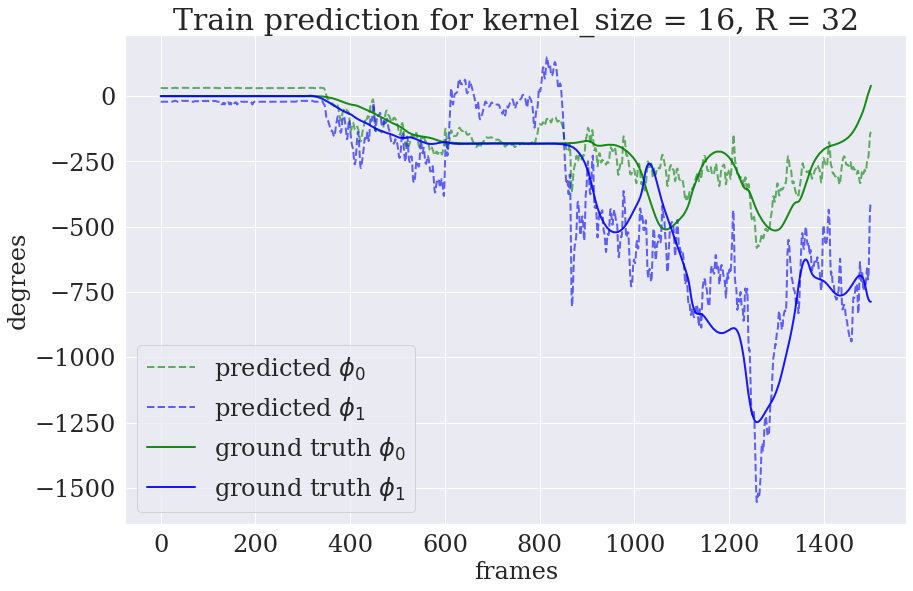

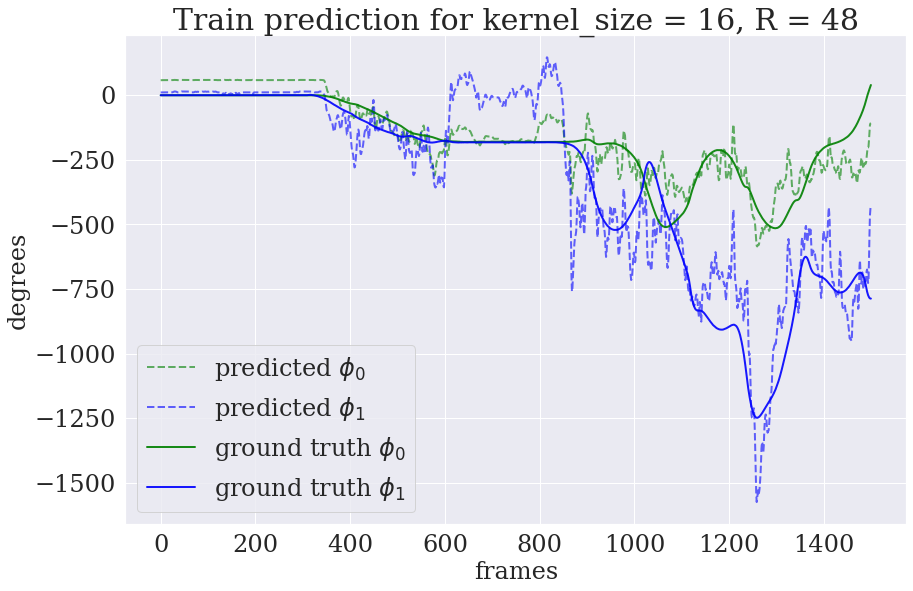

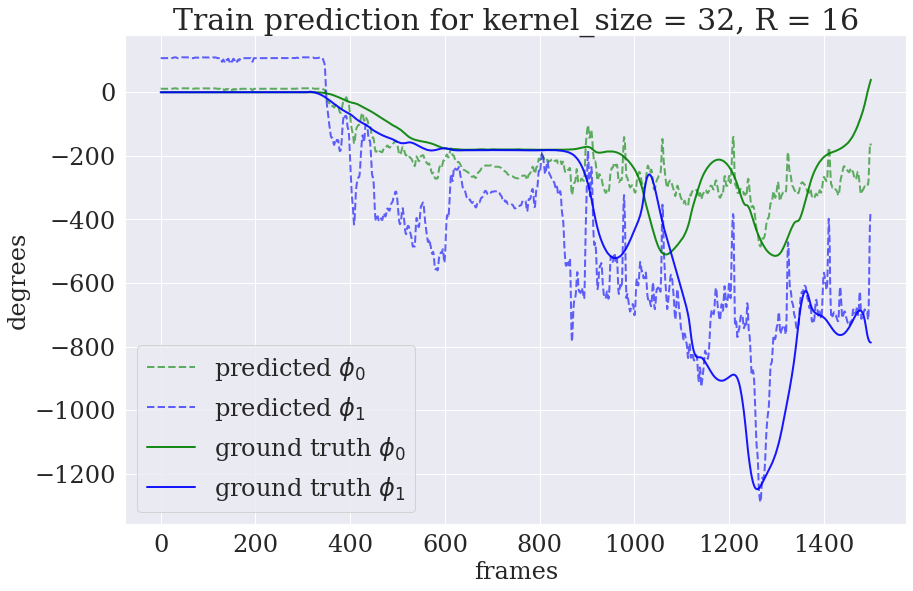

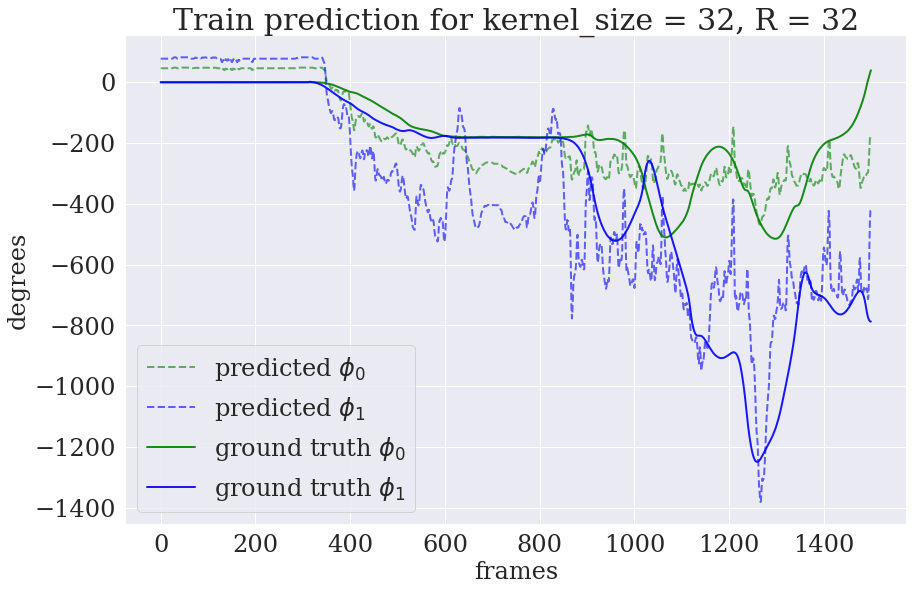

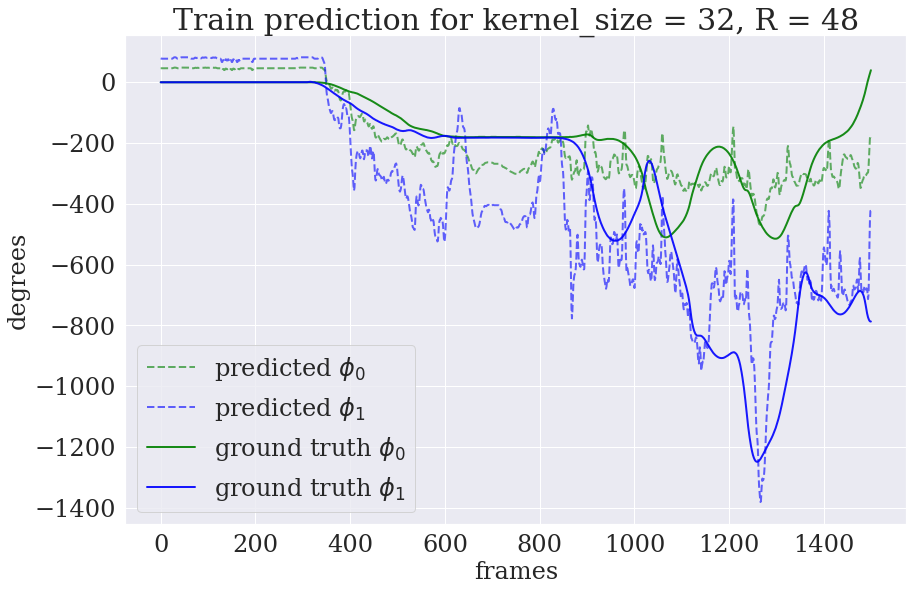

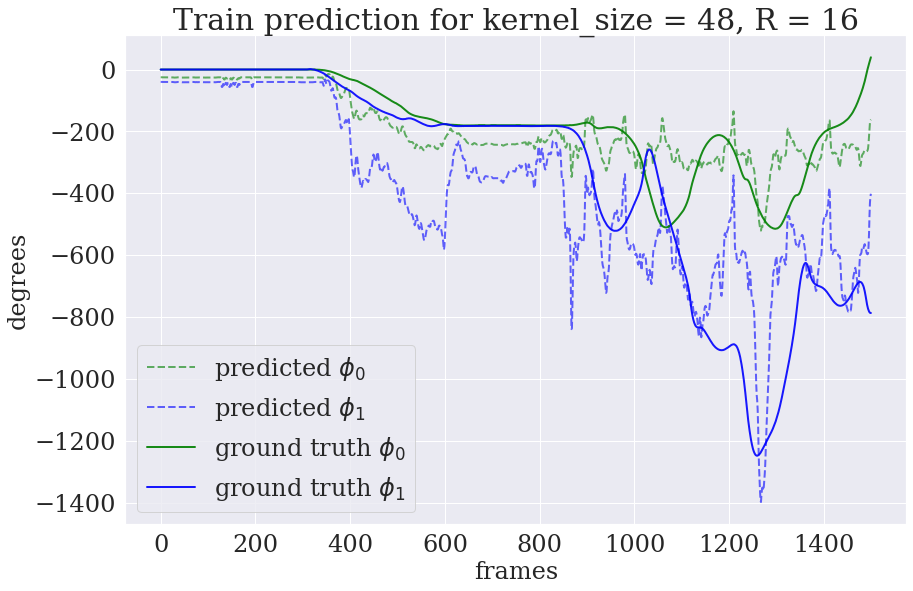

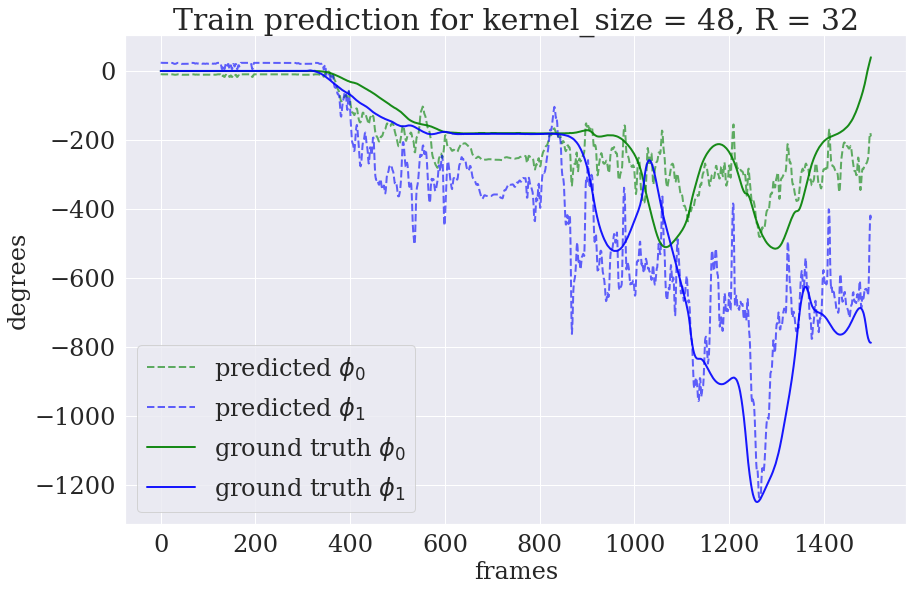

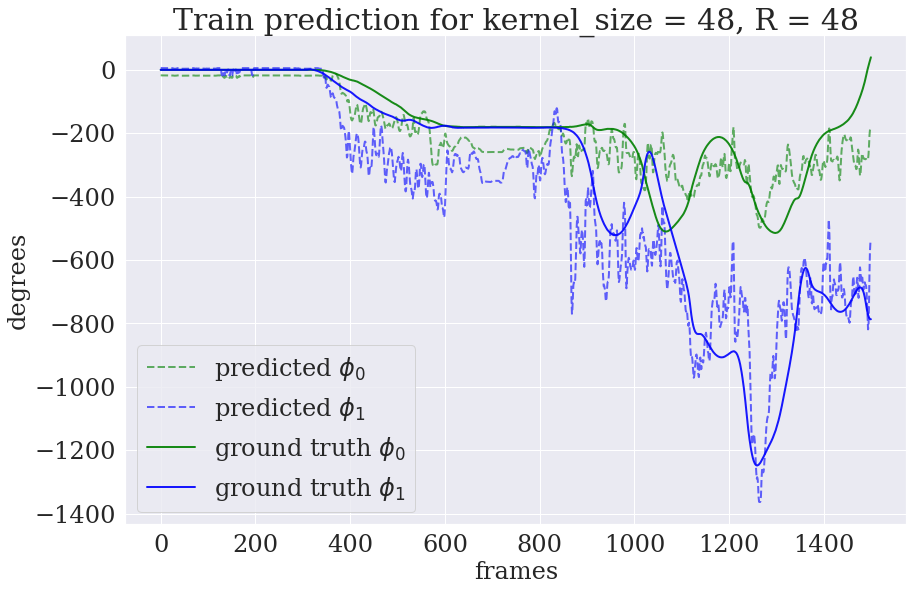

In [ ]:
for i in range(len(test_predicted)):
    plt.figure(figsize=(14, 9))
    plt.plot(predicted[i][:, 0], '--', c='green', alpha=0.6, label=r'predicted $\phi_0$')
    plt.plot(predicted[i][:, 1], '--', c='blue', alpha=0.6, label=r'predicted $\phi_1$')
    plt.plot(angles[:, 0], c='green', alpha=0.9, label=r'ground truth $\phi_0$')
    plt.plot(angles[:, 1], c='blue', alpha=0.9, label=r'ground truth $\phi_1$')

    plt.xlabel('frames')
    plt.ylabel('degrees')
    plt.title(f'Train prediction for kernel_size = {kernel_sizes[i // 3]}, R = {r_arr[i % 3]}')
    plt.legend()
    plt.savefig(f'train_pred_r_{r_arr[i % 3]}_kernel_{kernel_sizes[i // 3]}')
    plt.show()

**Визуализация предсказаний на тесте**

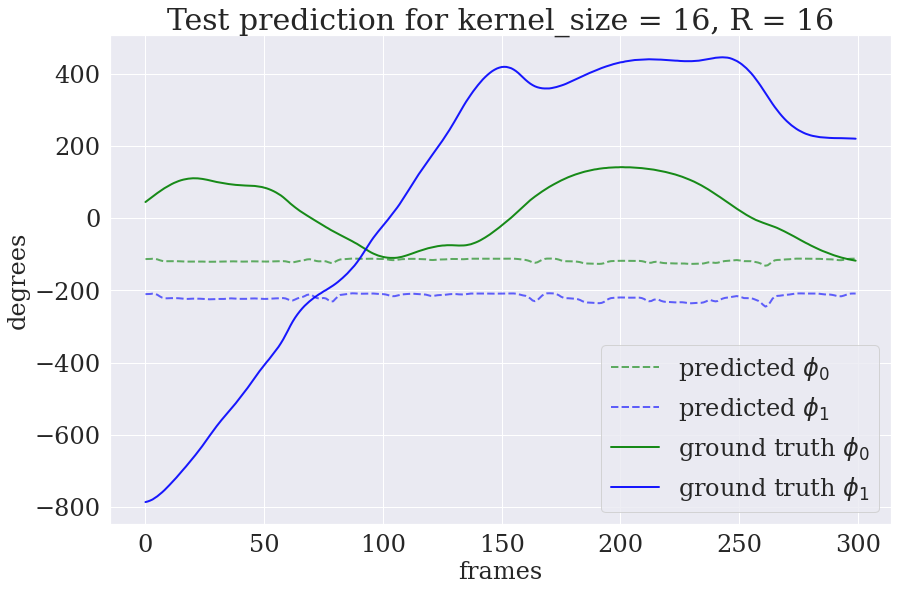

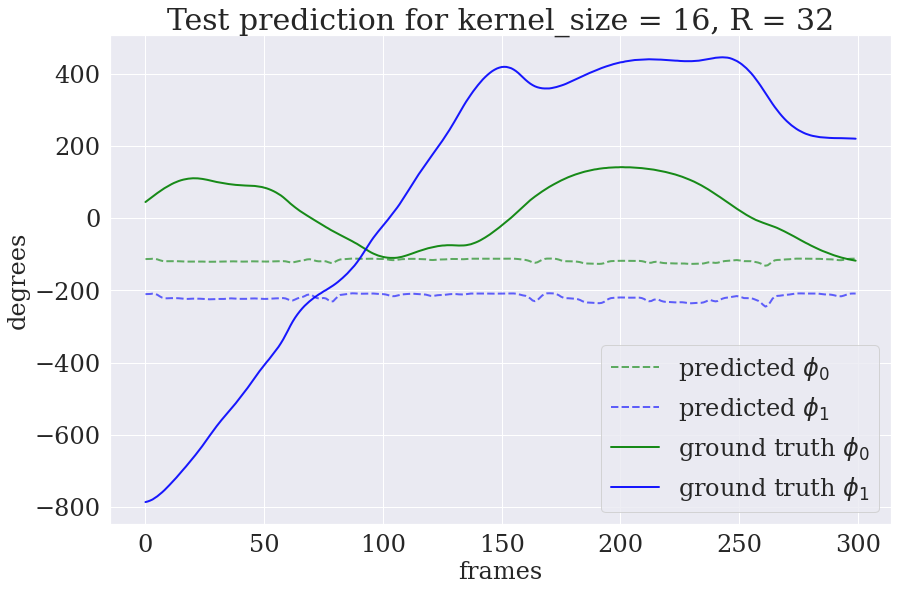

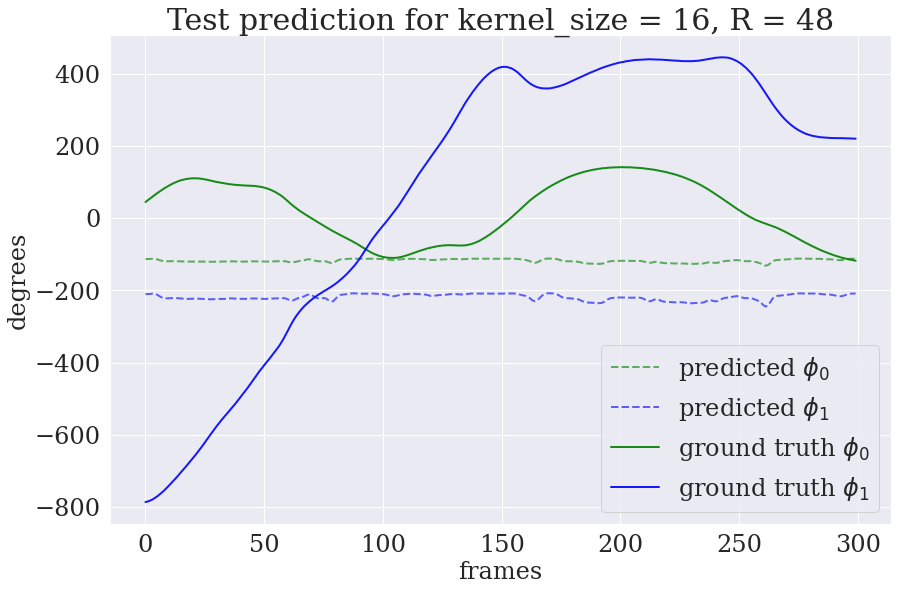

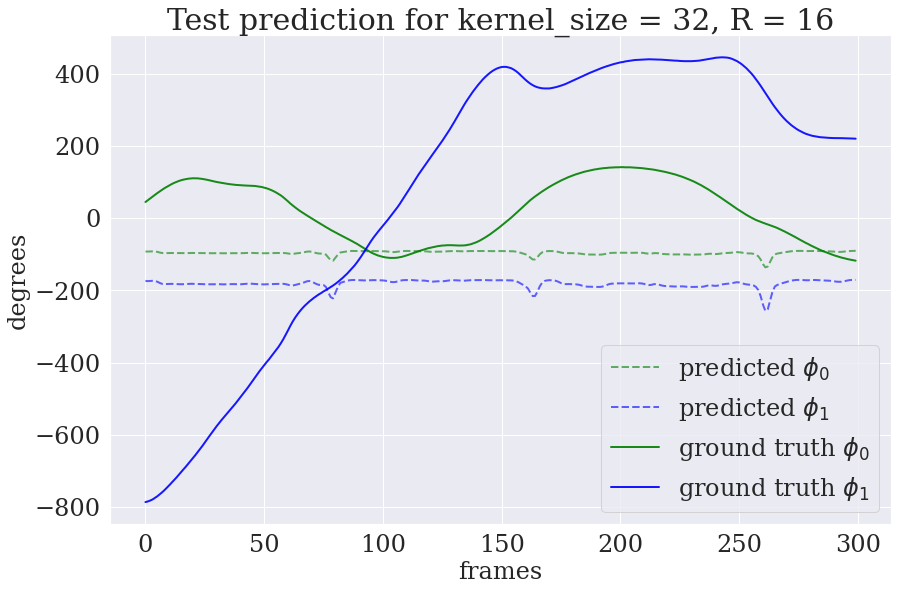

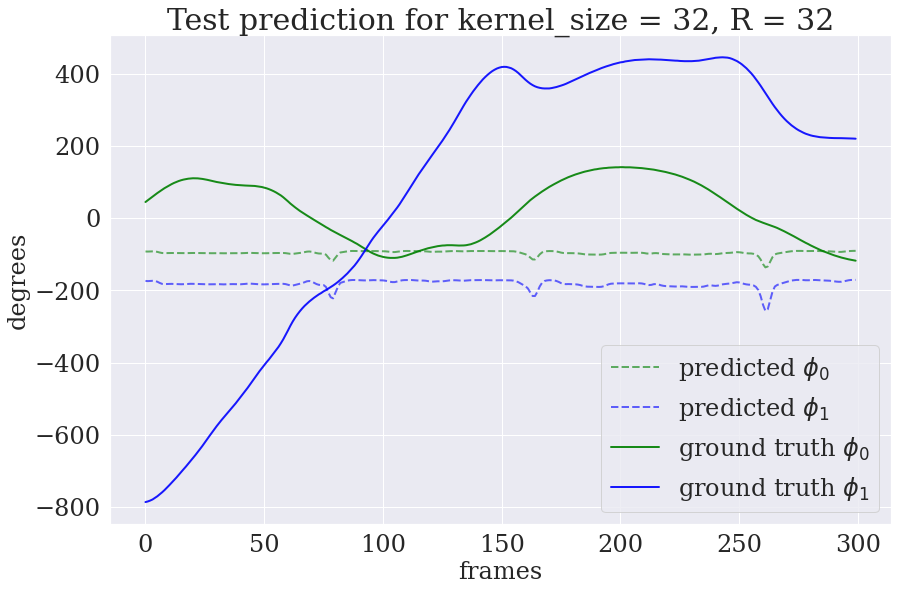

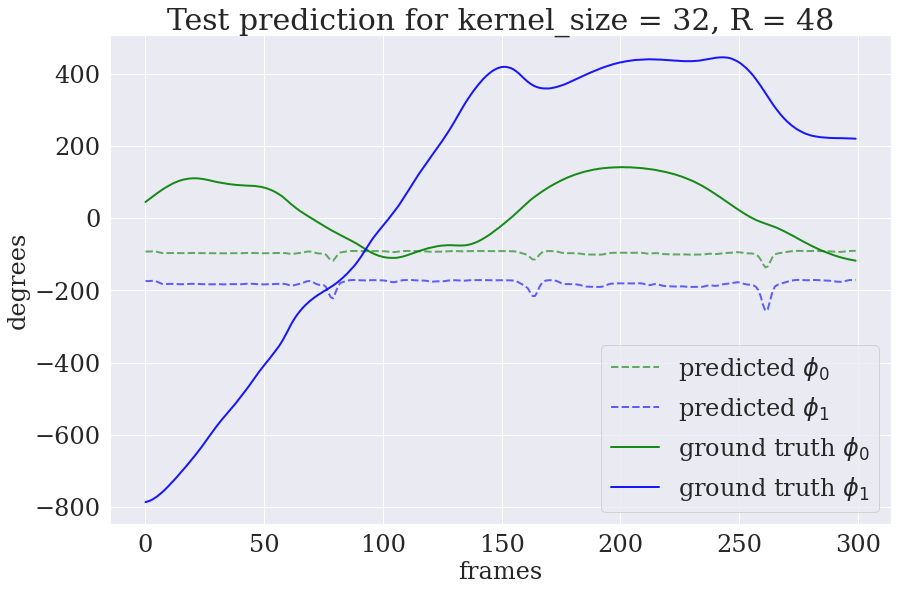

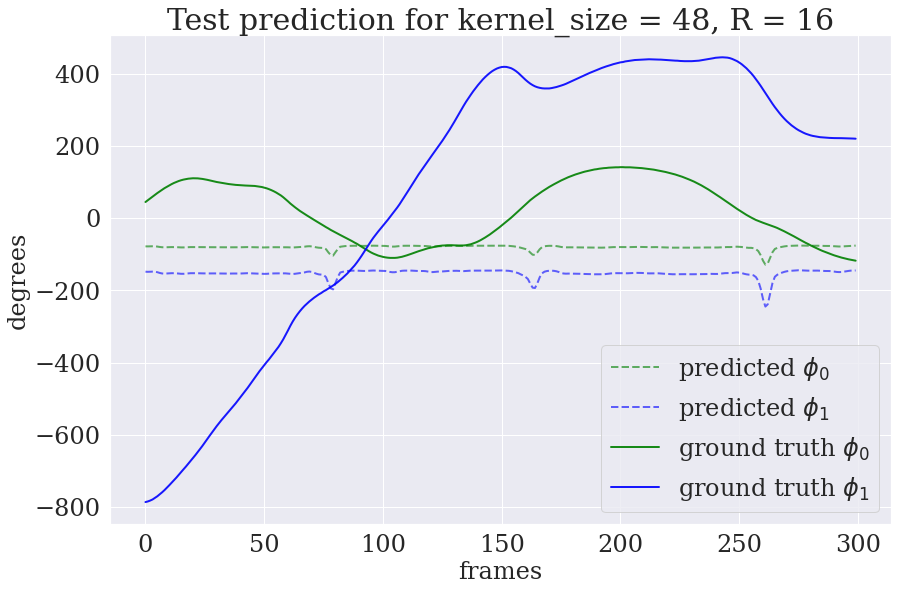

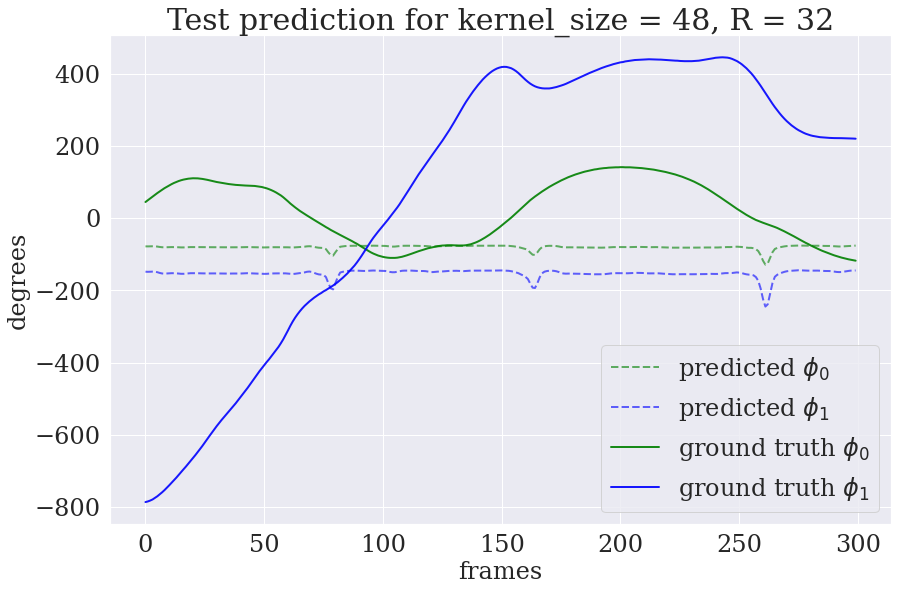

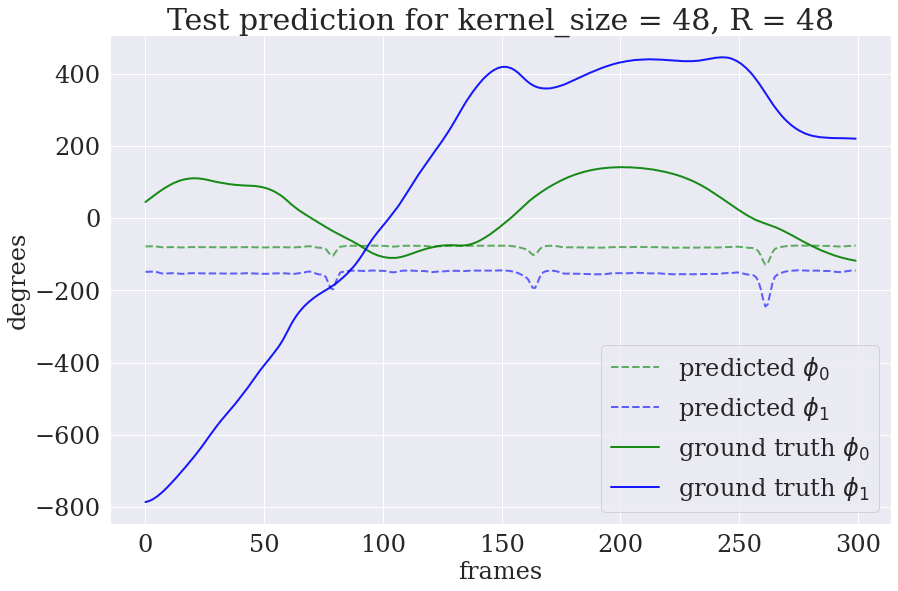

In [ ]:
for i in range(len(test_predicted)):
    plt.figure(figsize=(14, 9))
    plt.plot(test_predicted[i][:, 0], '--', c='green', alpha=0.6, label=r'predicted $\phi_0$')
    plt.plot(test_predicted[i][:, 1], '--', c='blue', alpha=0.6, label=r'predicted $\phi_1$')
    plt.plot(test_angles[:, 0], c='green', alpha=0.9, label=r'ground truth $\phi_0$')
    plt.plot(test_angles[:, 1], c='blue', alpha=0.9, label=r'ground truth $\phi_1$')

    plt.xlabel('frames')
    plt.ylabel('degrees')
    plt.title(f'Test prediction for kernel_size = {kernel_sizes[i // 3]}, R = {r_arr[i % 3]}')
    plt.legend()
    plt.savefig(f'test_pred_r_{r_arr[i % 3]}_kernel_{kernel_sizes[i // 3]}')
    plt.show()

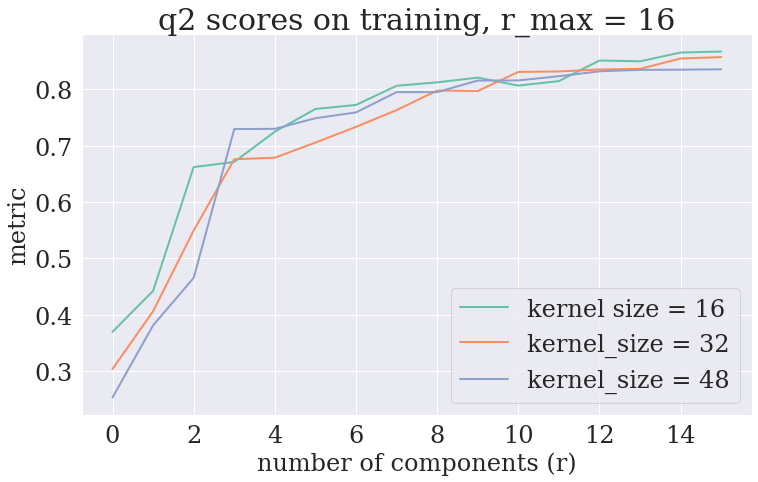

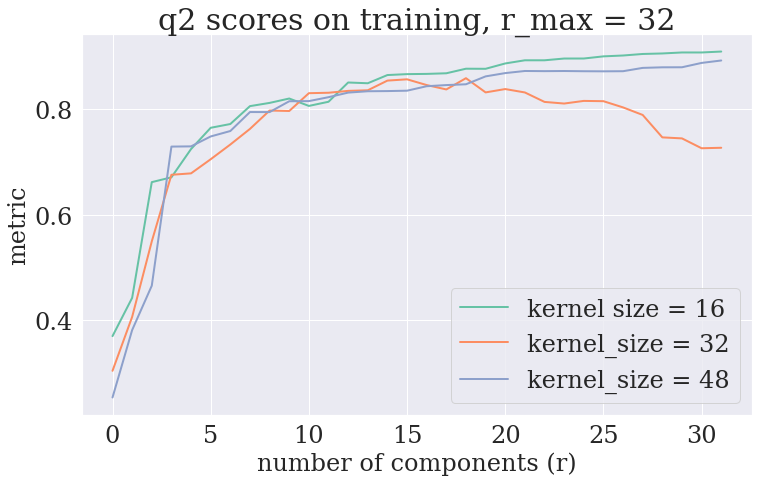

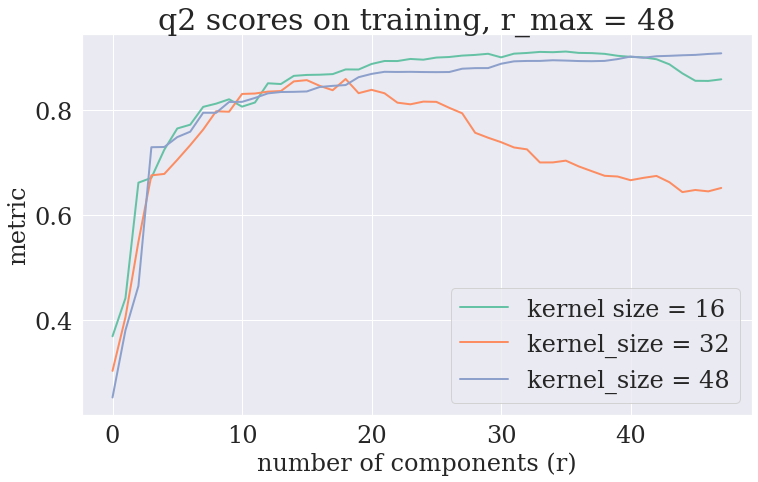

In [ ]:
for i in range(3):
    plt.plot(q2_scores[i + 3*0], label=f'kernel size = {kernel_sizes[0]}')
    plt.plot(q2_scores[i + 3*1], label=f'kernel_size = {kernel_sizes[1]}')
    plt.plot(q2_scores[i + 3*2], label=f'kernel_size = {kernel_sizes[2]}')

    plt.title(f'q2 scores on training, r_max = {r_arr[i]}')
    plt.xlabel('number of components (r)')
    plt.ylabel('metric')
    plt.legend()
    plt.savefig(f'q2_scores_r_{r_arr[i]}.png')
    plt.show()

# Предсказание азимута вместо кумулятивного значения угла

**Подготовка данных**

In [ ]:
target_df = pd.read_csv(
    'start_target_azi.csv'
)
angles = target_df.iloc[:, 1:].values.reshape(-1, 2, 1)

FREQ_REDUCTION_COEF = 3
MAX_TS_LEN = 1500
TEST_SIZE = 300
test_angles = angles[::FREQ_REDUCTION_COEF][MAX_TS_LEN:MAX_TS_LEN+TEST_SIZE]
angles = angles[::FREQ_REDUCTION_COEF][:MAX_TS_LEN]

traj_angles = tl.tensor(
    [angles[i:i+TRAJ_SIZE] for i in range(len(angles)-TRAJ_SIZE+1)],
)
traj_test_angles = tl.tensor(
    [test_angles[i:i+TRAJ_SIZE] for i in range(len(test_angles)-TRAJ_SIZE+1)],
)

**Обучение**

In [ ]:
# Trains near 15 minutes
KERNEL_SIZE = 48
Ln = [TRAJ_SIZE, KERNEL_SIZE, KERNEL_SIZE]
Km = [TRAJ_SIZE, 2, 1]
epsilon = 1e-3
R = 30

model = hopls.HOPLS(R, Ln, Km, epsilon=epsilon)
model.fit(traj_video, traj_angles)
prediction, _, prediction_scores = model.predict(traj_video, traj_angles)

/usr/local/lib/python3.8/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


**Получение предсказаний**

In [ ]:
def transform_traj_elem(traj_elem: np.ndarray) -> np.ndarray:
    assert traj_elem.ndim >= 3, 'Too low dimensions'
    ts, traj_dim = traj_elem.shape[:2]
    result = np.zeros((traj_dim+ts-1, traj_elem.shape[2]))

    traj_elem = traj_elem.squeeze()
    norm_coef = np.full(traj_dim+ts-1, traj_dim)

    for i in range(ts):
        if i < traj_dim:
            norm_coef[i] = i + 1
            norm_coef[-i-1] = i + 1
        
        result[i:i+traj_dim, :] += traj_elem[i]

    return result / norm_coef.reshape(-1, 1)


predicted_angles = transform_traj_elem(prediction.numpy())

**Значения метрик**

In [ ]:
print("MSE for phi_0 =", mse(angles[:, 0], predicted_angles[:, 0]))
print("MAE for phi_0 =", mae(angles[:, 0], predicted_angles[:, 0]))
print("R^2 for phi_0 =", r2(angles[:, 0], predicted_angles[:, 0]))

print("MSE for phi_1 =", mse(angles[:, 1], predicted_angles[:, 1]))
print("MAE for phi_1 =", mae(angles[:, 1], predicted_angles[:, 1]))
print("R^2 for phi_1 =", r2(angles[:, 1], predicted_angles[:, 1]))

MSE for phi_0 = 7950.92850485083
MAE for phi_0 = 70.63186206028948
R^2 for phi_0 = 0.44209307600273495
MSE for phi_1 = 3707.6069446178785
MAE for phi_1 = 39.42560479524581
R^2 for phi_1 = 0.7228500925043615


**График предсказаний**

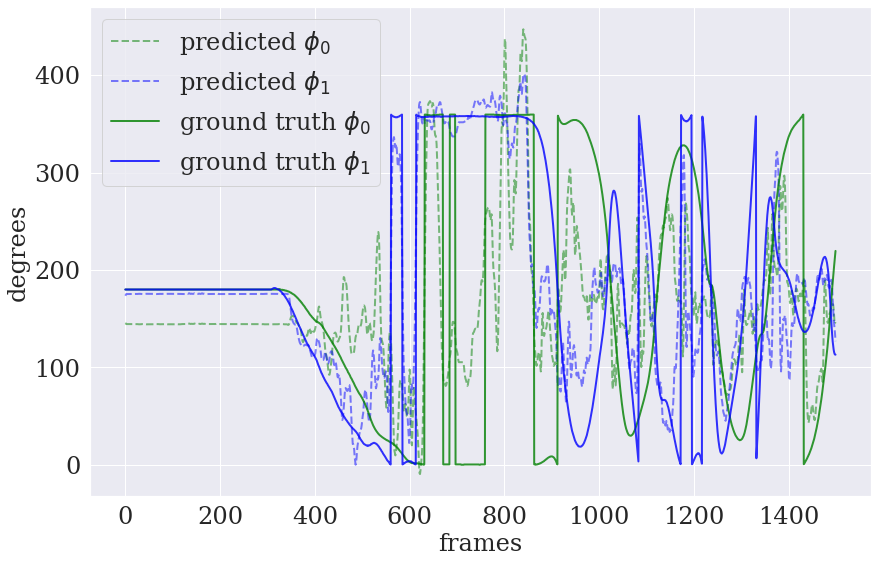

<Figure size 864x504 with 0 Axes>

In [ ]:
plt.figure(figsize=(14, 9))
plt.plot(predicted_angles[:, 0], '--', c='green', alpha=0.5, label=r'predicted $\phi_0$')
plt.plot(predicted_angles[:, 1], '--', c='blue', alpha=0.5, label=r'predicted $\phi_1$')
plt.plot(angles[:, 0], c='green', alpha=0.8, label=r'ground truth $\phi_0$')
plt.plot(angles[:, 1], c='blue', alpha=0.8, label=r'ground truth $\phi_1$')

plt.xlabel('frames')
plt.ylabel('degrees')
plt.legend()
plt.show()
plt.savefig('train_azi_example.png')

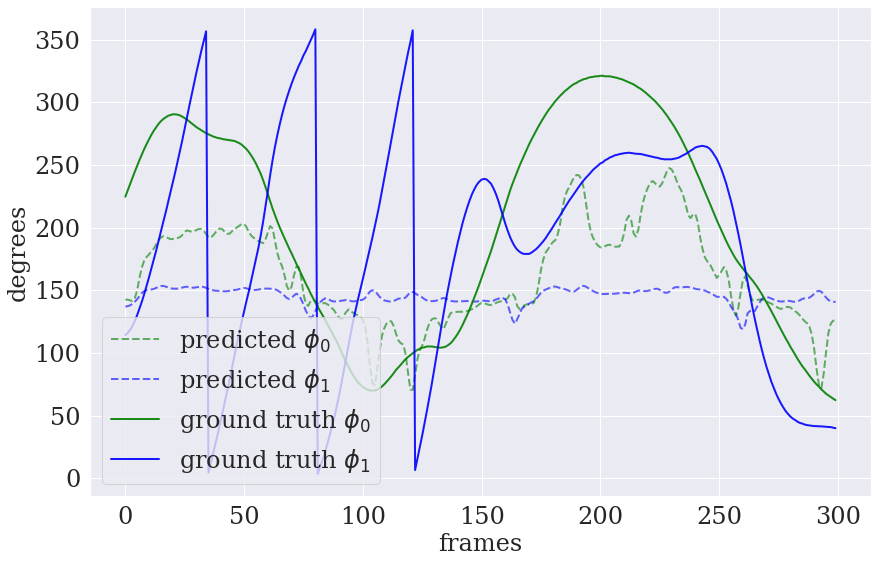

<Figure size 864x504 with 0 Axes>

In [ ]:
test_prediction, _, _ = model.predict(traj_test_video, traj_test_angles)
test_predicted_angles = transform_traj_elem(test_prediction.numpy())

plt.figure(figsize=(14, 9))
plt.plot(test_predicted_angles[:, 0], '--', c='green', alpha=0.6, label=r'predicted $\phi_0$')
plt.plot(test_predicted_angles[:, 1], '--', c='blue', alpha=0.6, label=r'predicted $\phi_1$')
plt.plot(test_angles[:, 0], c='green', alpha=0.9, label=r'ground truth $\phi_0$')
plt.plot(test_angles[:, 1], c='blue', alpha=0.9, label=r'ground truth $\phi_1$')

plt.xlabel('frames')
plt.ylabel('degrees')
plt.legend()
plt.show()
plt.savefig('test_azi_example.png')